# PMR3404 - Controle I
# Projeto Final (Ball on Wheel)

#### Bruno Fernandes Maione (10770631)
#### Victor Kowalski Martins (10770482)

#### Professores: Eduardo Aoun Tannuri e Newton Maruyama

#### Julho 2021

In [1]:
# Aqui importamos todas as bibliotecas que serão utilizadas no projeto

from sympy import *
from grafico_margens import plot_margins
import warnings
init_printing(use_unicode=True)
warnings.filterwarnings('ignore')
import control.matlab as co
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

### 1. Introdução

O presente trabalho tem o intuito de modelar o controle para um sistema denominado "Ball on Wheel". O mesmo consiste numa roda, de inércia não desprezível e acionada por um motor DC, sobre a qual se deve equilibrar uma bola. Um sensor de posição mede o deslocamento da bola em relação ao eixo vertical (isso é, a variável $y(t)$). O objetivo do sistema de controle é manter a bola no topo da roda. Assume-se que não há escorregamento entre as partes.

A Figura a seguir, expõe uma foto real do sistema em conjunto com um desenho esquemático.

![Picture title](Figuras/Real_Esquema.png)

A bola possui massa $m$, momento de inércia $\vartheta$ e raio $r$. A roda possui momento de inércia $\Theta$ e raio $R$.

O torque na roda é dado por $\tau(t)$. A posição angular da roda relativa ao eixo vertical é dada por $\psi(t)$, a posição angular da bola em torno do centro da roda é descrita por $\chi(t)$ e o deslocamento linear em relação ao eixo vertical, considerando que não há escorregamento, é dado por: $y(t) = (R+r)sin(\chi(t))$.

Sendo assim, considerando que as equações de movimento, de dinâmica do motor e os parâmetros físicos do sistema foram expostos no enunciado (e também serão expostos ao longo do desenvolvimento), pode-se prosseguir para a análise da planta para um posterior dimensionamento do controlador preterido.

### 2. Detalhamento da Planta

O primeiro passo a ser efetuado para o presente projeto é a definição e simplificação das equações de movimento, que deverão ser analisadas para uma futura construção do diagrama de blocos de nossa planta.

Como trabalharemos com ângulos pequenos e, principalmente, para possibilitar as transformadas de laplace posteriores, será utilizada a seguinte aproximação para os senos:

$$
sin(x) = x
$$

Tal aproximação, adaptada do primeiro limite fundamental do Cálculo, funciona para ângulos menores de 14º com erro de menor de 1%, o que se trata de uma precisão perfeitamente satisfatória para o projeto.

In [2]:
# Definindo as equações de movimento

t = symbols('t')
s = symbols('s')
m = symbols('m')
r = symbols('r')
R = symbols('R')
g = symbols('g')
v = symbols('vartheta')
O = symbols('Theta')
n = symbols('n')
Kt = symbols('K_t')
Kv = symbols('K_v')
Lm = symbols('L_m')
Rm = symbols('R_m')
T = symbols('Gamma')

y, psi, chi, u, i, V = symbols('y, psi, chi, u, i, V', cls=Function)

y = y(t)
y_dot = y.diff()
y_ddot = y_dot.diff()

psi = psi(t)
psi_dot = psi.diff()
psi_ddot = psi_dot.diff()

chi = chi(t)
chi_dot = chi.diff()
chi_ddot = chi_dot.diff()

u = u(t)
u_dot = u.diff()
u_ddot = u_dot.diff()

i = i(t)
i_dot = i.diff()
i_ddot = i_dot.diff()

V = V(t)
V_dot = V.diff()
V_ddot = V_dot.diff()

eq_y = Eq(y ,(R+r)*chi)
eq_psi_ddot = Eq(psi_ddot ,((m*(r**2) + v)*u + m*g*R*v*chi)/T)
eq_chi_ddot = Eq(chi_ddot ,(v*R*u + (O*(r**2) + v*(R**2))*m*g*chi)/(T*(r+R)))
eq_u = Eq(u ,n*Kt*i)
eq_V = Eq(V, Lm*i_dot + Rm*i + Kv*psi_dot)

Uma vez com as equações definidas no código, podemos realizar as manipulações no domínio da frequência, com as transformadas de laplace.

Como a biblioteca Sympy no Python não tem suporte nativo para transformadas de laplace com derivadas e integrais, devemos definir uma função (que aproveite o básico da biblioteca nativa) para abrangir tais funcionalidades e possibilite o uso ao longo das deduções, uma vez que essas peculiaridades com certeza seriam utilizadas.

In [3]:
def laplace_completa(e, t, s):
    """
        Função completa adaptada da biblioteca da transformada de laplace, acrescido do suporte à derivadas e integrais.
        Adaptada de: https://github.com/sympy/sympy/issues/7219#issuecomment-154768904

        Parâmetros
            Inputs: e (expressão simbólica à ser transformada), t (simbólico que representa o tempo), s (simbólico que representa o s de nossa transformada)
            Outputs: res (expressão simbólica após a transformada)
    """

    res = laplace_transform(e, t, s, noconds=True)
    wf = Wild('f')
    lw = LaplaceTransform(wf, t, s)

    for exp in res.find(lw):
        e = exp.match(lw)[wf]
        args = e.args

        if isinstance(e, Derivative):
            # for derivative check that there's only d/dt^n with n>0
            if len(args) == 2 and args[1][0] == t:
                n = args[1][1]
                if n > 0:
                    newexp = s**n * LaplaceTransform(e.args[0], t, s)
                res = res.replace(exp, newexp)

        elif isinstance(e, Integral):
            # for integral check that there's only n consecutive indefinite integrals w.r.t. t
            if all(len(arg) == 1 and arg[0] == t for arg in args[1:]):
                newexp = s**(-len(args[1:])) * LaplaceTransform(args[0], t, s)
                res = res.replace(exp, newexp)

        # caso não tenha derivada ou integral, segue sem entrar nos ifs

    return res

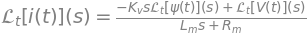

In [4]:
i_s = laplace_completa(i, t, s)
eq_i_s = Eq(i_s, solve(Eq(laplace_completa(eq_V.lhs,t,s), laplace_completa(eq_V.rhs,t,s)), i_s)[0])
eq_i_s

In [5]:
u_s = laplace_completa(u, t, s)
eq_u_s = Eq(u_s, solve(Eq(laplace_completa(eq_u.lhs,t,s), laplace_completa(eq_u.rhs,t,s)), u_s)[0])
eq_u_s

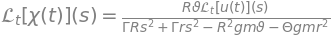

In [6]:
chi_s = laplace_completa(chi, t, s)
eq_chi_s = Eq(chi_s, solve(Eq(laplace_completa(eq_chi_ddot.lhs,t,s), laplace_completa(eq_chi_ddot.rhs,t,s)), chi_s)[0]).simplify()
eq_chi_s

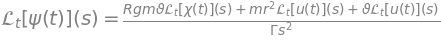

In [7]:
psi_s = laplace_completa(psi, t, s)
eq_psi_s = Eq(psi_s, solve(Eq(laplace_completa(eq_psi_ddot.lhs,t,s), laplace_completa(eq_psi_ddot.rhs,t,s)), psi_s)[0])
eq_psi_s

In [8]:
y_s = laplace_completa(y, t, s)
eq_y_s = Eq(y_s, solve(Eq(laplace_completa(eq_y.lhs,t,s), laplace_completa(eq_y.rhs,t,s)), y_s)[0])
eq_y_s

Com as expressões tranformadas para o domínio da frequência, podemos construir o diagrama de blocos (em malha aberta) de nosso sistema.

![Picture title](Figuras/db-inicial.png)

Chama-se $$\frac{R\vartheta}{\Gamma(R+r)s^2 - mg(\Theta r^2 + \vartheta R^2)}$$ de $$G_1(s)$$ e pode-se simplificar o diagrama de blocos da seguinte forma:

![Picture title](Figuras/db-intermediario.png)

Vamos agora realizar as outras operações para obtermos apenas um bloco de nossa planta.
As células a seguir realizam as mesmas, passo à passo, utilizando as funcionalidades do Python.

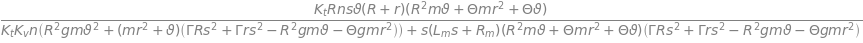

In [9]:
G1 = (eq_chi_s.rhs/u_s).simplify()

Gcima = (((Kt*n)/(Lm*s+Rm))*G1).simplify()

Gbaixo = ((R*g*m*v + (m*r**2+v)/G1)*(Kv/(s*(R**2*m*v + O*m*r**2 + O*v)))).simplify()

Gp = (Gcima/(1+Gcima*Gbaixo)*(R+r)).simplify()

Gp

Portanto, obtemos a função de transferência de nossa planta (malha aberta), substituindo o valor de $$G_1(s)$$, mostrada a seguir.

![Picture title](Figuras/db-final.png)

Como discutido com professores e outros colegas, para ao presente projeto iremos dimensionar nosso controlador para a variável $$Y(s)$$ diretamente.

Repare que agora será necessário realizar tal dimensionamento, para posteriormente fazermos teste com distúrbios no torque da roda, parâmetro físico mais interessante na presente problemática.

A malha fechada com nosso controlador fica, portanto, como mostrado a seguir.

![Picture title](Figuras/db-malha-fechada.png)

### 3. Dimensionamento do controlador

Um controlador PID pode ser pensado da seguinte forma:

$$G_c(s) = K_p (1+T_d s + \frac{1}{T_i s})$$

Para o qual devemos definir os parâmetros $K_p$, $T_d$, $T_i$. 

In [10]:
# Celula utilizada para conseguirmos pegar a expressão simbólica e transformá-la para Python, evitando erros na cópia
print_python(Gp)

K_t = Symbol('K_t')
R = Symbol('R')
n = Symbol('n')
s = Symbol('s')
vartheta = Symbol('vartheta')
r = Symbol('r')
m = Symbol('m')
Theta = Symbol('Theta')
K_v = Symbol('K_v')
g = Symbol('g')
Gamma = Symbol('Gamma')
L_m = Symbol('L_m')
R_m = Symbol('R_m')
e = K_t*R*n*s*vartheta*(R + r)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)/(K_t*K_v*n*(R**2*g*m*vartheta**2 + (m*r**2 + vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)) + s*(L_m*s + R_m)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2))


In [11]:
# Definição dos parâmetros numéricos

s = co.tf("s")

Theta = 0.028 # kg.m^2
R = 0.16 # m
m = 0.048 # kg
vartheta = 2.54e-5 #kg.m^2
r = 0.0296 #m
K_t = 0.1604 # N.m/A
K_v = 0.1186 # V.s/rad
R_m = 12 # ohm
L_m = 1.16e-3 # H
g = 9.8 # m/s^2
n = 40
Gamma = Theta*vartheta + m*(vartheta*(R**2) + Theta*(r**2))


Gp = K_t*R*n*s*vartheta*(R + r)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)/(K_t*K_v*n*(R**2*g*m*vartheta**2 + (m*r**2 + vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)) + s*(L_m*s + R_m)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2))

Vamos, como boa prática, analisar os polos e zeros de nossa função de transferência em malha aberta com os parâmetros numéricos definidos no $$\textit{briefing}$$ do projeto.

In [12]:
p_g = co.pole(Gp)
z_g = co.zero(Gp)
print(p_g, z_g)

[-1.03425992e+04  5.69671377e+00 -5.72218197e+00 -2.20289160e+00] [0.]


Nossa função de transferência com os valores numéricos fica, em adição, da seguinte forma:

In [13]:
print("VERSAO NAO SIMPLIFICADA")
print(Gp)

# Podemos realizar algumas manobras para simplificar ainda mais nossa funcao de transferencia, printamos sua versao simplificada logo abaixo

aux_simplifica = 1/(Gp.num[0][0][0])
Gpsimp = Gp*aux_simplifica/aux_simplifica

print("VERSAO SIMPLIFICADA")
print(Gpsimp)

VERSAO NAO SIMPLIFICADA

                              9.492e-12 s
-----------------------------------------------------------------------
8.107e-16 s^4 + 8.387e-12 s^3 + 1.866e-11 s^2 - 2.729e-10 s - 6.021e-10

VERSAO SIMPLIFICADA

                           s
--------------------------------------------------------
8.542e-05 s^4 + 0.8836 s^3 + 1.966 s^2 - 28.75 s - 63.44



Vamos agora definir as expressões de nosso controlador em Python.

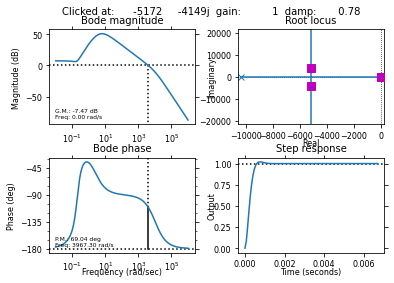

In [51]:
@interact(Kp=(0.01, 1500), Td=(0.01, 10), Ti=(0.01, 10))
def sistema(Kp, Td, Ti):
    Gc = Kp*(1+Td*s + 1/(Ti*s))
    co.sisotool(co.minreal(Gp*Gc, verbose=False))

Utilizando a técnica interativa, permitida operacionalmente dadas as ferramentas computacionais atuais (no caso, Python), foi possível projetar um PID que atende satisfatoriamente os requisitos desejados. Os valores dos parâmetros serão:

$$K_{p} = 500$$

$$T_{d} = 2$$

$$T_{i} = 2$$

Observa-se que o ganho de margem pode apresentar inconsistência dado o requisito do enunciado, mas percebe-se que isso é natural dado que é impossível fazer o ganho de margem ser maior que 10dB, uma vez que o gráfico das frequência é assintótico à -180º.

0 states have been removed from the model


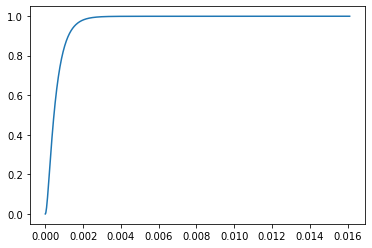

In [65]:
Kp = 150
Td = 10
Ti = 0.5

Gc = Kp*(1+Td*s + 1/(Ti*s))
Gfinal = co.minreal(Gc*Gp, verbose=False)
Gfmf  = co.minreal(co.feedback(Gfinal))
y, t = co.step(Gfmf)
plt.plot(t, y)

In [67]:
print(co.stepinfo(Gfinal))

IndexError: index 0 is out of bounds for axis 0 with size 0

### 4. Ponderações sobre o esforço de controle

Para todo projeto de controle, é necessário tentar avaliar o esforço de controle, uma vez que determinada solução pode não ser a mais eficiente em termos de esforço para sua realização. O esforço de controle é a quantidade de energia ou força necessários para que o controlador realize sua atividade corretamente.

Assim sendo, adaptamos o código do laboratório para analisar o esforço de controle da presente planta estudada.

In [23]:
esforco = co.minreal(co.feedback(Gc, Gp), verbose=False)

print(esforco)
try:
    co.stepinfo(esforco)
except Exception as e:
    print(f"{e} \n^^^ A função de transferência é imprópria, o que impossibilida o prosseguimento das simulações")


1100 s^6 + 1.138e+07 s^5 + 4.808e+07 s^4 - 3.083e+08 s^3 - 1.532e+09 s^2 - 2.004e+09 s - 8.17e+08
-------------------------------------------------------------------------------------------------
                s^5 + 1.034e+04 s^4 + 1.29e+07 s^3 + 2.542e+07 s^2 + 1.214e+07 s

Transfer function is non-proper; can't convert to StateSpace system. 
^^^ A função de transferência é imprópria, o que impossibilida o prosseguimento das simulações


Como visto na célula anterior, a função de transferência para o sistema de controle montado é imprópria, o que, infelizmente, impossibilita a realização do estudo do esforço de controle.

Isso ocorre, porque o grau da expressão do numerador é maior do que o grau da expressão no denominador (mais zeros do que polos).

Essa propriedade, do porquê simulações com um função de transferência imprópria não poderem ser realizadas, vale a pena ser demonstrada, haja visto o detalhamento que deve-se ter para o presente projeto.

Seja suposto o seguinte modelo de espaço de estados:

$$\dot{x} = Ax +Bu$$

$$y = Cx +Du$$

onde $A \in \mathbb{R}^{n \times n}$. Realizando a transformada de Laplace de ambas as equações de estado e a equação de output, conclui-se que a função de transferência é a seguinte função de matrizes:

$G(s) = C(sI_{n}-A)^{-1}B+D$

Pode-se notar que 

$(sI_{n}-A)^{-1} = \frac{adj(sI_{n}-A)}{det(sI_{n}-A)}$

E que:

- Cada entrada da matriz adjunta é um polinômio em $s$ com grau no máximo igual à $n-1$;

- O determinante de $(sI_{n}-A)$ é um polinômio em $s$ com grau $n$.

Assim, conclui-se que cada uma das $n^2$ funções de transferência SISO (single-input single-output/uma entrada uma saída) de $G(s)$ tem a propriedade que o grau do numerador é menor ou igual ao grau do denominador.

Para simularmos uma função de transferência imprópria, portanto, derivadas do input deveriam ser necessárias. O problema é que não é possível realizar derivadas perfeitas.

O módulo da frequência de resposta de um diferenciador aumenta com a frequência. No entanto, não é possível construir um aparato cujo ganho se torna arbitrariamente alto com altas frequências. Caso contrário, qualquer aparelho que conhecemos teriam que possuir uma frequência de corte a partir da qual sua resposta falharia.

Ou, seja suposto um sinal descontínuo em um diferenciador perfeito. Ele teria que computar a derivada do sinal, antes de notar que a derivada não existe. Então, qualquer diferenciador é, no máximo, uma aproximação.

Assim sendo, entende-se o porquê de não ser possível computar e analisar o esforço de controle para o presente projeto. Pode-se, portanto, partir para análises de respota do sistema quando sobre aplicações de distúrbios.

In [39]:
G1 = R*vartheta/(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)

Gesfcima = Gc*1/(L_m*s + R_m)
Gesfbaixo = ((1/Gc*K_v/(s*(R**2*m*vartheta+Theta*m*r**2+Theta*vartheta))
    *(R*g*m*vartheta+(m*r**2 + vartheta)/G1)*1/(R+r)+1)*K_t*n*G1*(R+r))

Gesf = co.minreal(co.feedback(Gesfcima, Gesfbaixo))
print(Gesf)

1 states have been removed from the model

9.483e+05 s^6 + 3.793e+06 s^5 - 2.517e+07 s^4 - 1.196e+08 s^3 - 1.842e+08 s^2 - 1.234e+08 s - 3.086e+07
-------------------------------------------------------------------------------------------------------
     s^6 + 1.035e+04 s^5 + 1.292e+07 s^4 + 5.123e+07 s^3 + 7.588e+07 s^2 + 4.969e+07 s + 1.214e+07



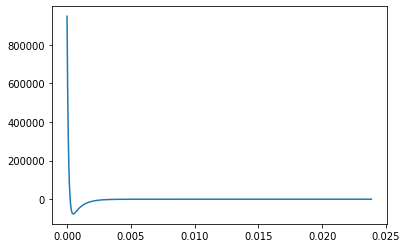

In [40]:
y, t = co.step(Gesf)
plt.plot(t, y)

### 5. Aplicações de distúrbios

Como o presente projeto é físicamente intuitivo e intrigante em termos de interações com usuários externos, é extremamente válido observar o comportamento do sistema com o controlador projetado ao ser exposto a distúrbios externos. Em termos práticos, considera-se nulo o setpoint, $Y_{sp}(s) = 0$, uma vez que a intenção será observar como a montagem reage ao tentar trazer a bola para cima, na posição de equilíbrio instável, na qual o valor de $Y$ é justamente nulo. A Figura a seguir apresenta o diagrama de blocos com a consideração do distúrbio.

![Picture title](Figuras/db-disturbios.png)


Serão realizados 4 testes principais, variando o comportamento de $D(s)$, escolhidos seguindo a usualidade de projetos de controle e a curiosidade dos membros, os quais pensaram em testes plausíveis que seriam realizados por usuários externos ao entrar em contato com o sistema.

#### 5.1 Degrau

O primeiro teste a ser realizado representa a consideração de $D(s)$ como um degrau (step). Fisicamente, seria como se a bolinha sofresse esforços equivalentes a ser constantemente empurrada 1cm (amplitude do degrau escolhido) fora de sua posição de equilíbrio. O sistema deve ser capaz de fazer a mesma voltar, isto é, compensar esse distúrbio.

O código abaixo expõe a construção do presente teste. A aplicação do degrau foi feita a partir de $0.25\;s$.

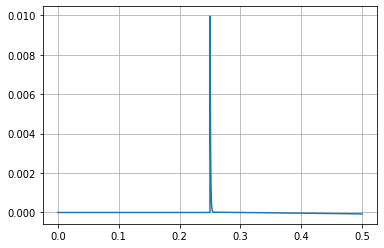

In [47]:
t = np.linspace(0, 500e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//2:] = 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

# y, t = co.impulse(co.feedback(1, Gfinal))
plt.figure()
plt.plot(t,y)
plt.grid()

Percebe-se que o sistema responde bem a esse distúrbio, fazendo a bolinha retornar a sua posição de equilíbrio muito rapidamente.

#### 5.2 Impulso

Um dos testes mais interessantes a ser feito, equivale a um "peteleco" externo na bolinha. Espera-se novamente que o sistema seja capaz de fazer a mesma retornar a sua posição de equilíbrio instável rapidamente.

O código abaixo expõe a construção do presente teste. A aplicação do impulso foi feita em $0.5\;s$.

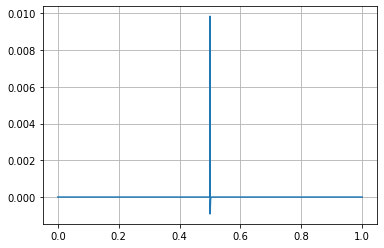

In [20]:
t = np.linspace(0, 1000e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//2] = 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

plt.figure()
plt.plot(t,y)
plt.grid()

Percebe-se que o sistema responde bem a esse distúrbio, fazendo a bolinha retornar a sua posição de equilíbrio muito rapidamente. Porém, como esperado fisicamente, a bolinha passa por uma espécie de sobressinal, isto é, retorna até o equilíbrio mas o passa por uma distância pequena. Tal erro é corrigido logo na sequência, uma vez que a mesma retorna para a posição de equilíbrio no sentido contrário.

#### 5.3 Alternância de impulsos na mesmo sentido

Para este terceiro teste, serão utilizados impulsos no mesmo sentido em diferentes intantes de tempo. Fisicamente, representa dois "petelecos" no mesmo sentido. O primeiro acontece aos $0.25\;s$ e o segundo aos $0.5\;s$.

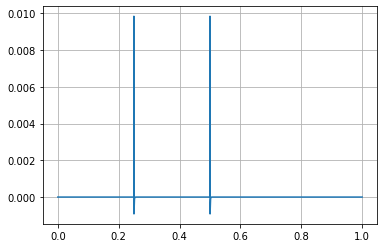

In [21]:
t = np.linspace(0, 1000e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//4] = 0.01

entrada[len(t)//2] = 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

plt.figure()
plt.plot(t,y)
plt.grid()

Percebe-se que o sistema responde bem a esse distúrbio, fazendo a bolinha retornar a sua posição de equilíbrio muito rapidamente nas duas vezes. Porém, assim como para o caso com apenas um "peteleco", como esperado fisicamente, a bolinha passa por uma espécie de sobressinal, isto é, retorna até o equilíbrio mas o passa por uma distância pequena. Tal erro é corrigido logo na sequência, uma vez que a mesma retorna para a posição de equilíbrio no sentido contrário.

#### 5.4 Alternância de impulsos com sentidos contrários

No último teste, realiza-se algo similar ao anterior, porém com dois "petelecos" em sentidos contrários. O primeiro acontece aos $0.25\;s$ e o segundo aos $0.5\;s$.

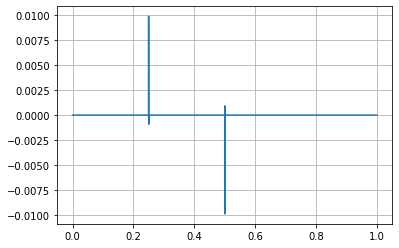

In [22]:
t = np.linspace(0, 1000e-3, 10000)
entrada = np.zeros(len(t))
entrada[len(t)//4] = 0.01

entrada[len(t)//2] = - 0.01
y,t,xout= co.lsim(co.feedback(1, Gfinal), entrada, t)

plt.figure()
plt.plot(t,y)
plt.grid()

Percebe-se que o sistema responde bem a esse distúrbio, fazendo a bolinha retornar a sua posição de equilíbrio muito rapidamente nas duas vezes. Porém, assim como para os casos anteriores, como esperado fisicamente, a bolinha passa por uma espécie de sobressinal, isto é, retorna até o equilíbrio mas o passa por uma distância pequena. Tal erro é corrigido logo na sequência, uma vez que a mesma retorna para a posição de equilíbrio no sentido contrário, para ambos os impulsos realizados.


### 6. Discussões

Aqui comentar sobre destrinchamento da planta

Aqui colocar sobre o método de dimensionamento

Sobre o fato de nao simular esforco de controle

Sobre os gráficos quanto a desturbios

COLOCAR LINK DO GIT HUB TALVEZ (?)

### 7. Conclusões

Uma vez dimensionado o sistema de controle, obtidos os gráficos e discutidas suas representações, considerando aspectos físicos, pode-se encerrar o presente relatório com conclusões gerais do trabalho. Inicialmente, deve-se ressaltar o caráter físico da problemática, isto é, por ser uma planta com traços e necessidades (requisitos) comuns no ramo da engenharia, dá-se enorme valor ao tratamento de suas equações e à resolução por métodos analíticos e computacionais. Tal valor, combinado com considerações desenvolvidas em diversas linguagens e bibliotecas, agrega valor para à engenharia tanto no sentido acadêmico, quanto no de mercado.

Adicionalmente, dado o caráter didático da disciplina, deve-se citar a relevância do aprofundamento e desenvolvimento de diferentes métodos para a resolução do presente trabalho. Assim como visto na teoria, em aula, pode-se colocar em prática o conhecimento recebido e observar, com os próprios olhos, o trade-off sempre presente na engenharia: entre precisão e esforço analítico-computacional, geralmente conectado com o tempo de obtenção de uma solução. Leva-se, portanto, para a posteridade da equipe, o contato com o traquejo ao se procurar não uma solução ideal, mas sim a solução suficientemente adequada (sempre com segurança) para a realização de projetos futuros e análise de fenômenos físicos.

Por fim, o contato com ferramentas importantes para a indústria atual, como Python e suas bibliotecas (simbólicas, relacionadas à controle e algébricas), completam e agregam ao trabalho mais um aprendizado valoroso. Encerra-se o presente estudo, não só com o treino de habilidades qualitativas, mas também com o aperfeiçoamento de habilidades técnico-operacionais, as quais não são, de modo algum, comparáveis entre si, sendo únicas e importantes de maneiras diferentes para a realização de um estudo acadêmico e de um projeto de engenharia.

### 8. Agradecimentos

Utiliza-se o espaço deste trabalho para realizar um agradecimento aos docentes da disciplina. A disciplina se mostrou extremamente divertida e cativante. Dessa forma, achamos importante ressaltar esses momentos durante nossa graduação. Nosso muito obrigado e até uma próxima!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4b5d483-a464-4b27-a020-25b9883aaa56' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>